In [2]:
# Start loading libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [3]:
xls_file=pd.ExcelFile("/Users/sanyamchaudhary/Downloads/RBRTEd.xls") # Read Excel
brent=xls_file.parse("Data 1") # Read sheet Data 1
brent.columns=brent.iloc[1] # set row 1 as column name
brent=brent[2:] # remove first 2 rows
brent["Date"]=brent["Date"].astype('datetime64[ns]') # Convert column to date format
brent.columns=["date","oil_price"]
brent.head()

,date,oil_price
2,1987-05-20,18.63
3,1987-05-21,18.45
4,1987-05-22,18.55
5,1987-05-25,18.6
6,1987-05-26,18.63


In [4]:
brent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7641 entries, 2 to 7642
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       7641 non-null   datetime64[ns]
 1   oil_price  7641 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 119.5+ KB


In [5]:
# Loop to read all share price files and transform data
shares=["RDSB.L","BP.L","CNE.L","PMO.L","STL.OL","FP.PA","REP.MC","ENGI.PA","SLB.PA"]

all_data=pd.DataFrame() # here we will store all the data from all shares and oil price in a master dataframe
for index in range(len(shares)):
    stock=pd.DataFrame()

# 1.- Read files
    stock=pd.read_csv("/Users/sanyamchaudhary/Downloads/"+shares[index]+".csv")     
# 2.- Transform data
    stock=stock[["Date","Close"]]       
    stock["Date"]=stock["Date"].astype('datetime64[ns]')
    stock.columns=["date","share_price"]
    test=pd.DataFrame(brent) # VLOOKUP equivalent in Python to merge 2 sets of data
    output=stock.merge(test,on="date",how="left")
    stock["oil_price"]=output["oil_price"]
    stock['share_price']=pd.to_numeric(stock['share_price'], errors='coerce').dropna(0)
    stock['oil_price']=pd.to_numeric(stock['oil_price'], errors='coerce').dropna(0)
    stock["year"]=pd.to_datetime(stock["date"]).dt.year # Create a column with the year to filter later
    stock["name"]=shares[index]
    stock = stock.dropna() # get rid of all the NAN rows.
# 3.- Feature Engineering. Create new column with scaled share price from 0 to 1.
#     This will help us comparing companies later on.
    from sklearn.preprocessing import MinMaxScaler
    scaler=MinMaxScaler()
    stock["share_price_scaled"]=scaler.fit_transform(stock["share_price"].to_frame())
# 4.- Append data to a master dataframe
    all_data=all_data.append(stock) #append data to one matrix
    
all_data.head()

,date,share_price,oil_price,year,name,share_price_scaled
0,2000-05-15,1193.597412,28.26,2000,RDSB.L,0.309123
1,2000-05-16,1191.409302,28.78,2000,RDSB.L,0.307755
2,2000-05-17,1164.911255,28.40,2000,RDSB.L,0.291187
3,2000-05-18,1204.315063,28.90,2000,RDSB.L,0.315824
4,2000-05-19,1215.334106,29.01,2000,RDSB.L,0.322714


<AxesSubplot: xlabel='date'>

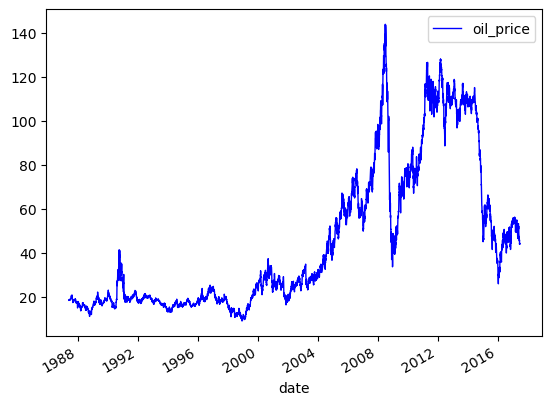

In [6]:
brent[['date','oil_price']].set_index('date').plot(color="blue", linewidth=1.0)  


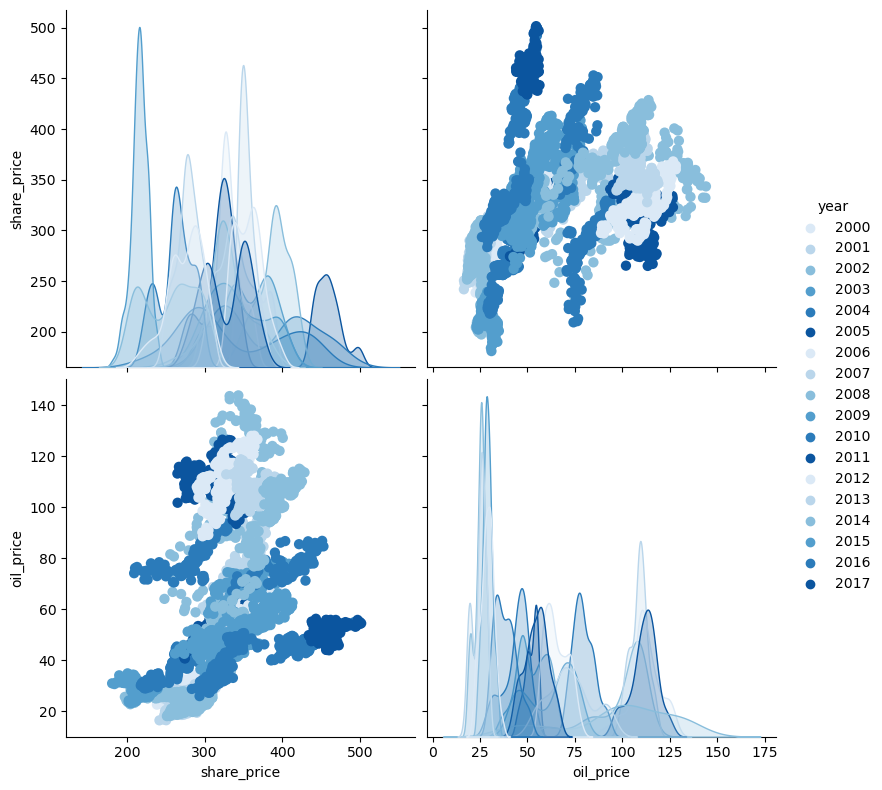

In [11]:
#==============================================================================
# Pairplot using master data table (all_data) with a filter on BP share price
#==============================================================================
import seaborn as sns  # Make sure to import seaborn if you haven't already

# Define a blueish color palette
blueish_palette = sns.color_palette("Blues")

# Create the pairplot with the blueish palette
sns.pairplot(all_data[all_data['name'] == "BP.L"].drop(["share_price_scaled"], axis=1),
             hue="year", palette=blueish_palette, size=4, markers="o",
             plot_kws=dict(s=55, edgecolor="b", linewidth=0))



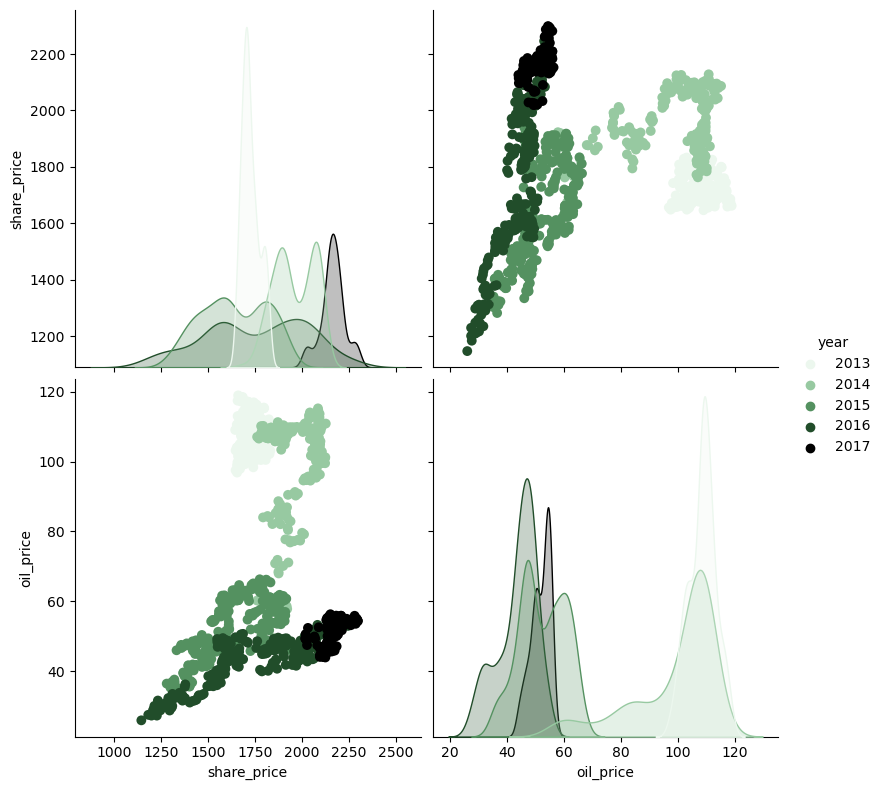

In [14]:
#==============================================================================
# Pairplot on less data 2013 to 2017 using Royal Dutch Shell (LON) stock price
#==============================================================================

# Just for the last 5 years
all_data13=all_data[all_data["year"]>2012]
palette=sns.cubehelix_palette(5, start=2, rot=0, dark=0, light=.95, reverse=False)
sns.pairplot(all_data13[all_data13['name']=="RDSB.L"].drop(["share_price_scaled"],axis=1),
             hue="year",palette=palette,size=4,markers="o",
             plot_kws=dict(s=50, edgecolor="b", linewidth=0))


<AxesSubplot: xlabel='year', ylabel='oil_price'>

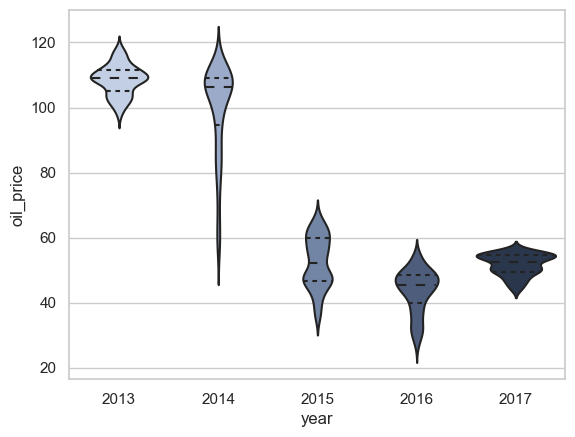

In [16]:
#==============================================================================
# Violin Plot Oil price on last 5 years
#==============================================================================

sns.set_style("whitegrid")
palette=sns.cubehelix_palette(5, start=2.8, rot=0, dark=0.2, light=0.8, reverse=False)

sns.violinplot(x="year", y="oil_price", data=all_data13[all_data13['name']=="RDSB.L"],
               inner="quart", palette=palette, trim=True)


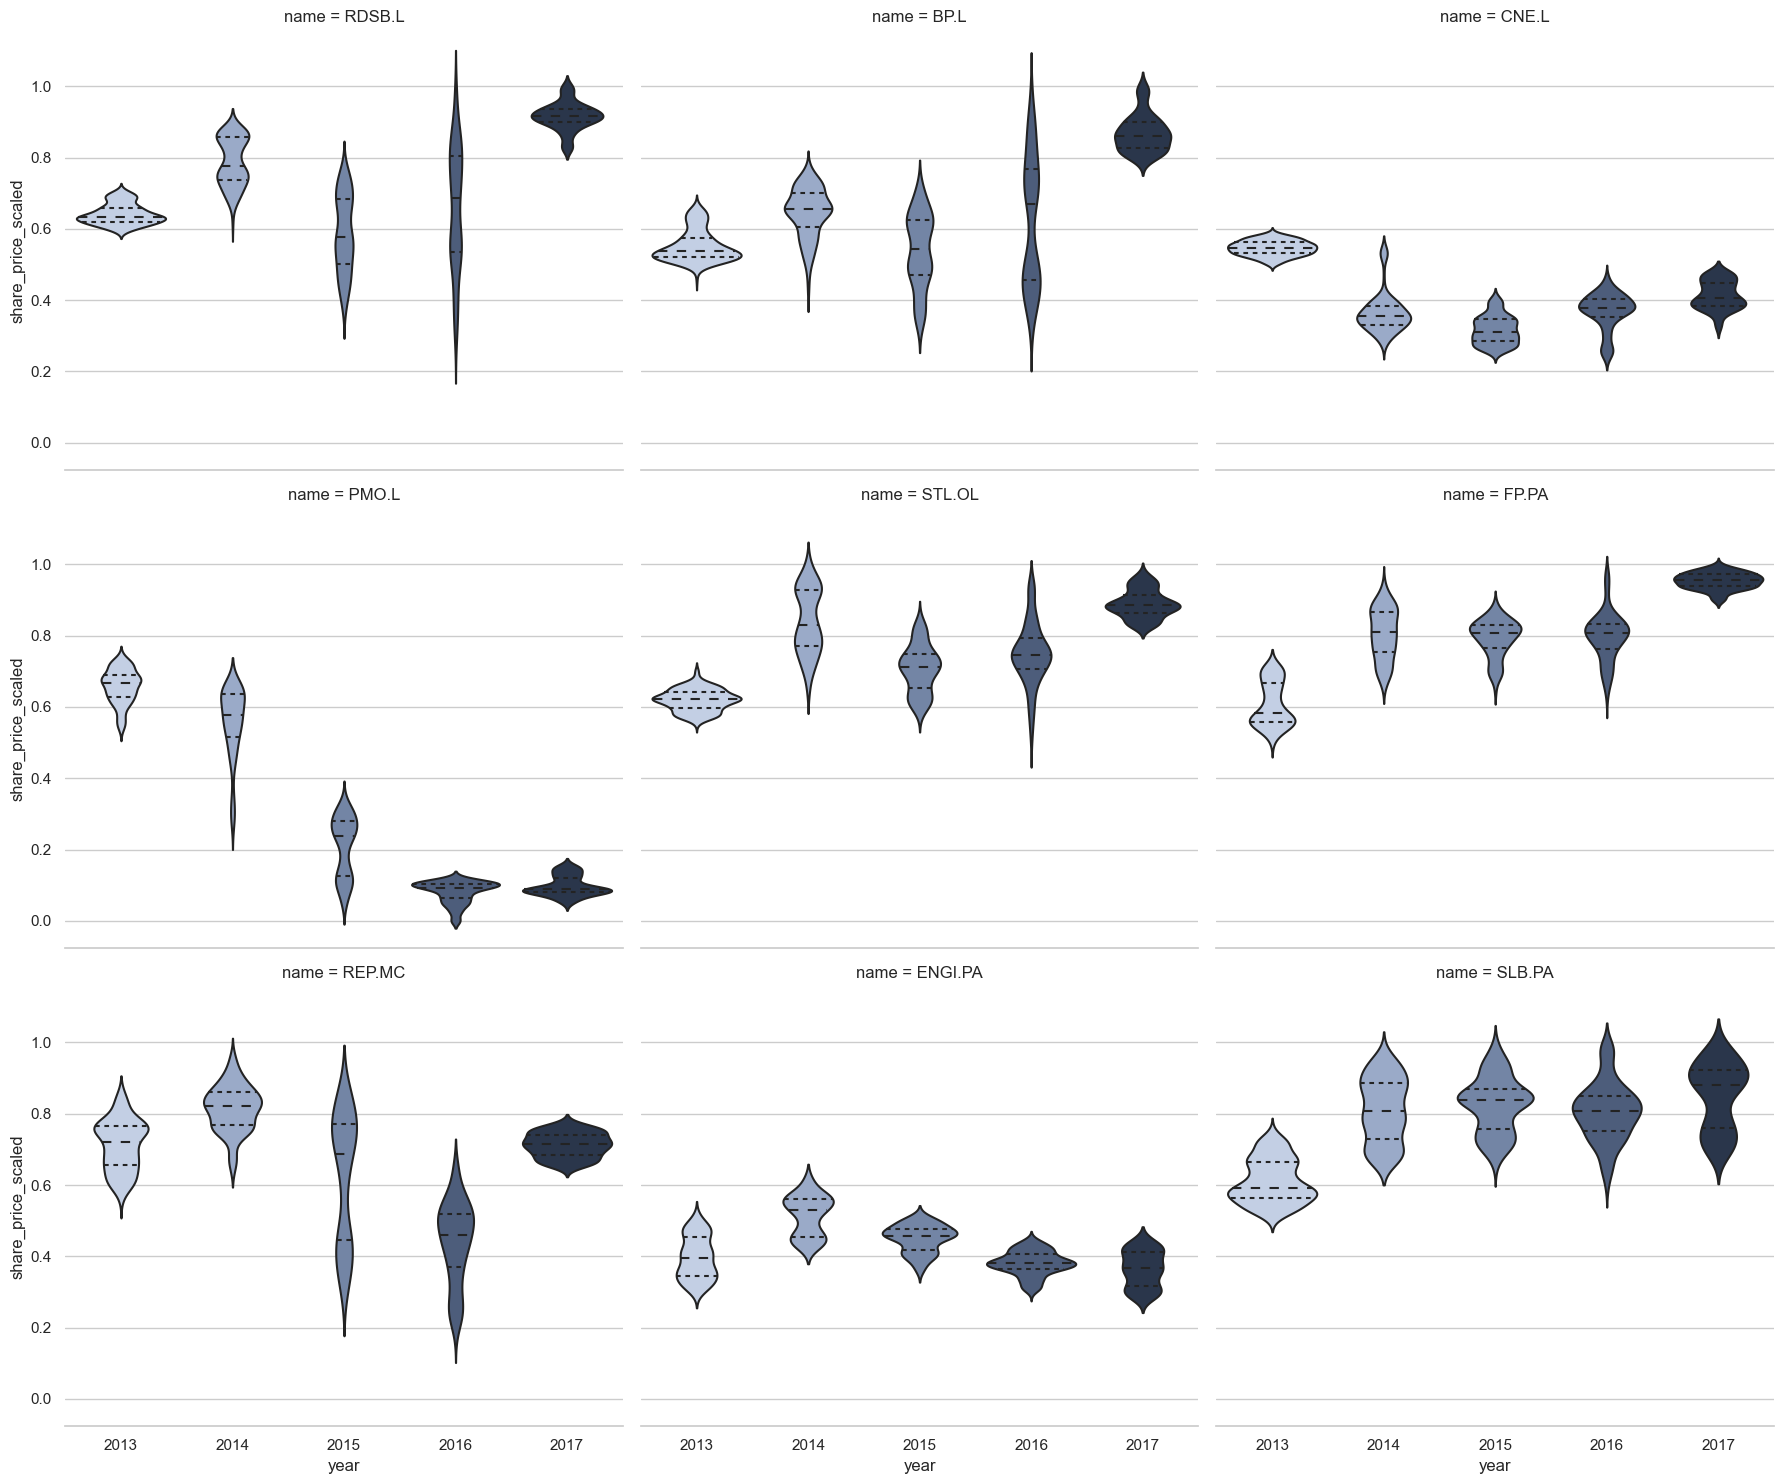

In [18]:
#==============================================================================
# Violin Plot Oil price on last 5 years
#==============================================================================

import seaborn as sns

# Create a violin plot with multiple subplots
sns.set(style="whitegrid")
g = sns.catplot(
    x="year", 
    y="share_price_scaled", 
    col='name', 
    col_wrap=3,
    kind="violin",
    split=True, 
    data=all_data13,
    inner="quart", 
    palette=palette,
    trim=True,
    size=4,
    aspect=1.2
)

# Remove spines from the left side
sns.despine(left=True)

# Show the plot


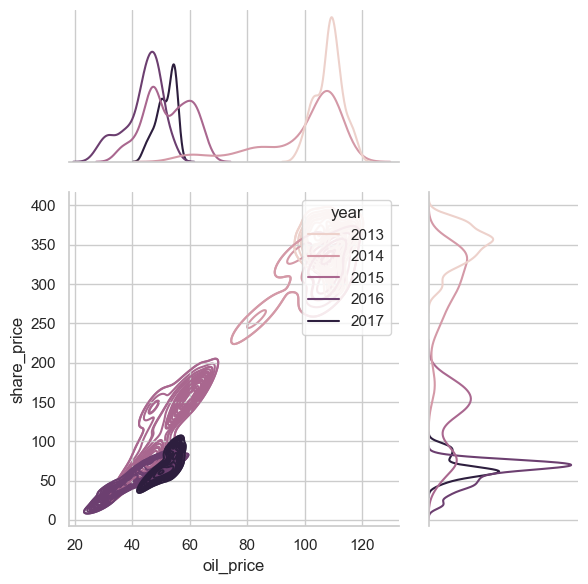

In [30]:
#==============================================================================
# joint plot using 5 years for Premier Oil
#==============================================================================
import seaborn as sns

filtered_data = all_data13[all_data13['name'] == "PMO.L"]
plot = sns.jointplot(
    x="oil_price", y="share_price", data=filtered_data,
    kind="kde", hue="year", height=6, ratio=2, color="red"
)
plot.plot_joint(sns.kdeplot, zorder=0, levels=20)


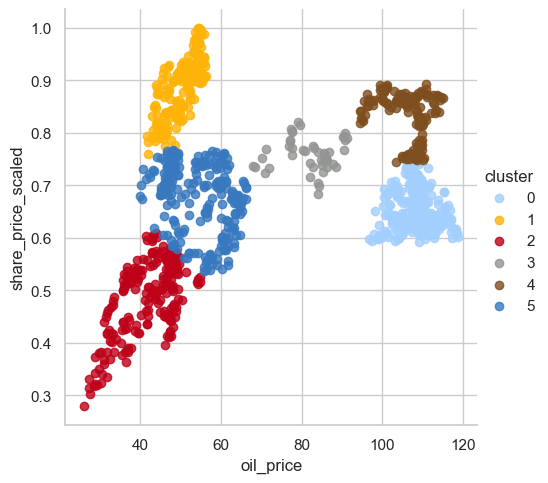

In [31]:
from sklearn.cluster import KMeans

shell=pd.DataFrame()
shell=all_data13[all_data13['name']=="RDSB.L"]
# We need to scale also oil price, so clustering is not influenced by the relative size of one axis.
shell["oil_price_scaled"]=scaler.fit_transform(shell["oil_price"].to_frame())
shell["cluster"] = KMeans(n_clusters=6, random_state=1).fit_predict(shell[["share_price_scaled","oil_price_scaled"]])

# The 954 most common RGB monitor colors https://xkcd.com/color/rgb/
colors = ["baby blue", "amber", "scarlet", "grey","milk chocolate", "windows blue"]
palette=sns.xkcd_palette(colors)

sns.lmplot(x="oil_price", y="share_price_scaled",ci=None,palette=palette, hue="cluster",fit_reg=0 ,data=shell)

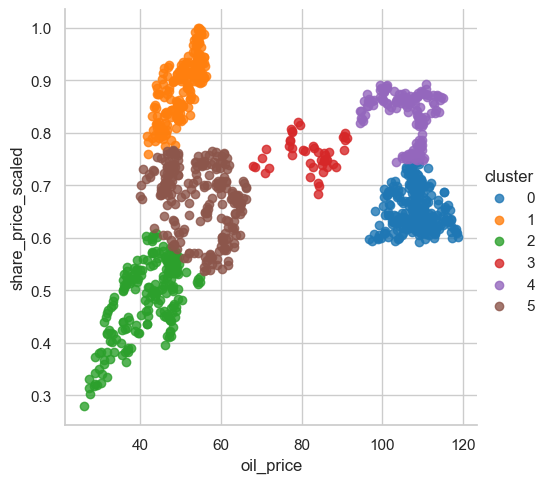

In [22]:
#==============================================================================
# Unsupervised Learning - Cluster analysis on Shell data
#==============================================================================
import seaborn as sns
from sklearn.cluster import KMeans

# Create a DataFrame for Shell data
shell = all_data13[all_data13['name'] == "RDSB.L"].copy()

# Scale the "oil_price" feature
shell["oil_price_scaled"] = scaler.fit_transform(shell["oil_price"].to_frame())

# Perform KMeans clustering with 6 clusters
shell["cluster"] = KMeans(n_clusters=6, random_state=1).fit_predict(shell[["share_price_scaled", "oil_price_scaled"]])

# Define custom colors for the clusters
custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

# Create a custom color palette
palette = sns.color_palette(custom_colors)

# Create a cluster plot using lmplot
sns.lmplot(x="oil_price", y="share_price_scaled", ci=None, palette=palette, hue="cluster", fit_reg=False, data=shell)


In [23]:
#==============================================================================
# Supervised learning linear regression
#==============================================================================
from sklearn import linear_model

# 1.- Data preparation
shell15 = all_data13[(all_data13['name'] == "RDSB.L") & (all_data13['year'] > 2015)]  # Extract data from years 2016/17
shell15 = shell15[["share_price", "oil_price"]].reset_index()

# Just using 1 variable for linear regression. To try with more variables use randomforest
# Split the data into training/testing sets
train = shell15[:-100]
test = shell15[-100:]

x_train = train["oil_price"].to_frame()  # Converts the pandas Series to numpy.ndarray
y_train = train['share_price'].to_frame()
x_test = test["oil_price"].to_frame()  # Converts the pandas Series to numpy.ndarray
y_test = test['share_price'].to_frame()

# 2.- Create linear regression object
regr = linear_model.LinearRegression()

# 3.- Train the model using the training sets
regr.fit(x_train, y_train)

# The coefficients
print("Coefficients: ", float(regr.coef_))
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(x_train) - y_train) ** 2))


Coefficients:  35.254081691242774
Mean squared error: 23210.67


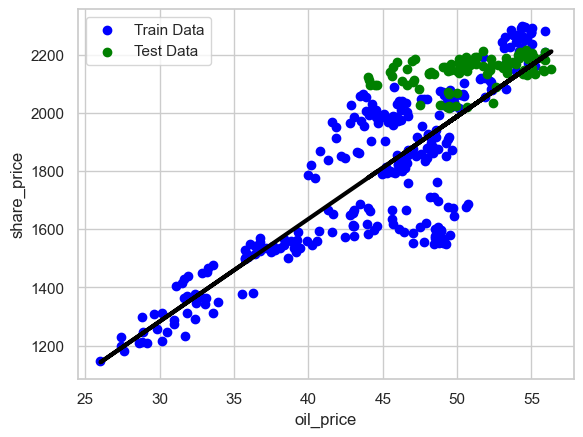

In [24]:
import matplotlib.pyplot as plt

# Plot training data in grey
plt_train = plt.scatter(x_train, y_train, color='blue', label='Train Data')

# Plot test data in green
plt_test = plt.scatter(x_test, y_test, color='green', label='Test Data')

# Plot the regression line in black
plt.plot(x_train, regr.predict(x_train), color='black', linewidth=3)
plt.plot(x_test, regr.predict(x_test), color='black', linewidth=3)

# Set labels and legend
plt.xlabel("oil_price")
plt.ylabel("share_price")
plt.legend(handles=[plt_train, plt_test], loc='upper left')

# Show the plot
plt.show()


In [25]:
from sklearn.ensemble import RandomForestRegressor
# 1.- Data Preparation
shell15=pd.DataFrame()
shell15=all_data13[(all_data13['name']=="RDSB.L") & (all_data13['year']>2015 )]
shell15=shell15[["share_price","oil_price"]].reset_index()

# Load share price of other variables
shell15['PMO.L']=all_data13[(all_data13['name']=="PMO.L")][-373:].reset_index()['share_price']
shell15['CNE.L']=all_data13[(all_data13['name']=="CNE.L")][-373:].reset_index()['share_price']
shell15['FP.PA']=all_data13[(all_data13['name']=="FP.PA")][-373:].reset_index()['share_price']
shell15['ENGI.PA']=all_data13[(all_data13['name']=="ENGI.PA")][-373:].reset_index()['share_price']

train = shell15[:-100]
test = shell15[-100:]

x_train=train[["oil_price","PMO.L","CNE.L","FP.PA","ENGI.PA"]]
y_train=train['share_price']

x_test=test[["oil_price","PMO.L","CNE.L","FP.PA","ENGI.PA"]] 
y_test=test['share_price'].to_frame()


# 2.- Create Randomforest object usinig a max depth=5
regressor = RandomForestRegressor(n_estimators=200, max_depth=5 )

# 3.- Train data
clf=regressor.fit(x_train, y_train)

# 4.- Predict!
y_pred=regressor.predict(x_test)
y_pred=pd.DataFrame(y_pred)

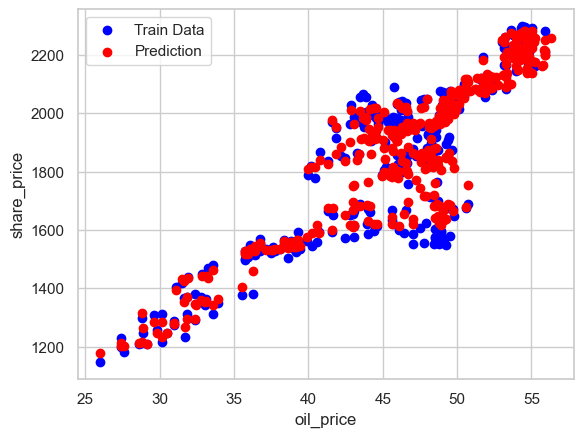

In [26]:
import matplotlib.pyplot as plt

# Plot training data in grey
plt_train = plt.scatter(x_train["oil_price"], y_train, color='blue', label='Train Data')

# Plot predicted data in black
plt_pred = plt.scatter(shell15["oil_price"], regressor.predict(shell15[["oil_price", "PMO.L", "CNE.L", "FP.PA", "ENGI.PA"]]), color='red', label='Prediction')

# Set labels and legend
plt.xlabel("oil_price")
plt.ylabel("share_price")
plt.legend(handles=[plt_train, plt_pred], loc='upper left')

# Show the plot
plt.show()


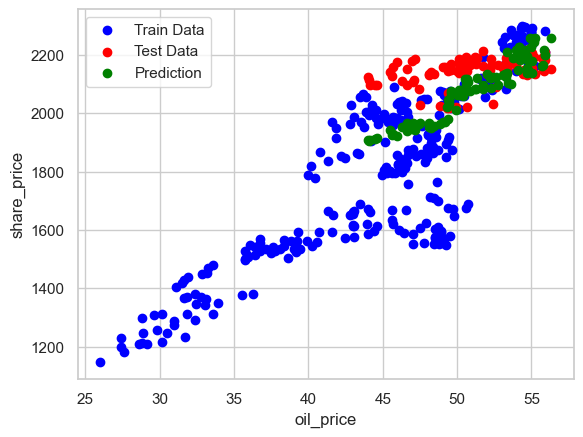

In [27]:
import matplotlib.pyplot as plt

# Plot training data in blue
plt_train = plt.scatter(x_train["oil_price"], y_train, color='blue', label='Train Data')

# Plot test data in red
plt_test = plt.scatter(x_test["oil_price"], y_test, color='red', label='Test Data')

# Plot prediction data in green
plt_pred = plt.scatter(x_test["oil_price"], y_pred, color='green', label='Prediction')

# Set labels and legend
plt.xlabel("oil_price")
plt.ylabel("share_price")
plt.legend(handles=[plt_train, plt_test, plt_pred], loc='upper left')

# Show the plot
plt.show()


In [28]:
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regressor.predict(x_train) - y_train) ** 2))

Mean squared error: 2544.06


Feature ranking:
Feature oil_price (0.193834)
Feature PMO.L (0.052685)
Feature CNE.L (0.121961)
Feature FP.PA (0.545653)
Feature ENGI.PA (0.085867)


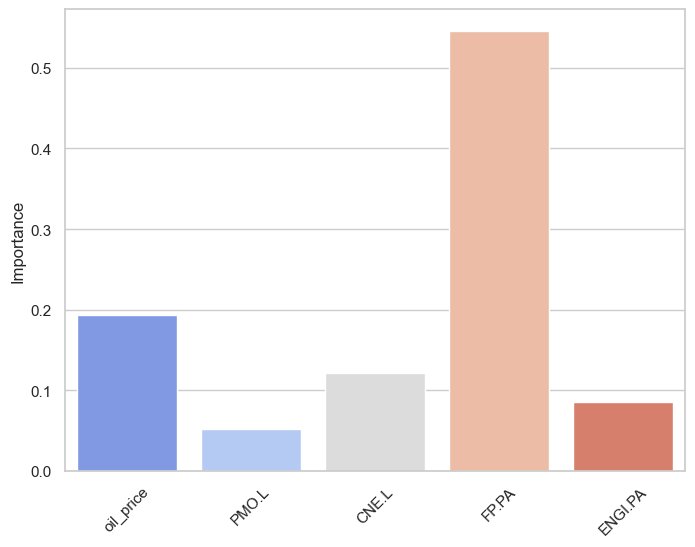

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

importances = regressor.feature_importances_
indices = list(x_train.columns)

print("Feature ranking:")
for f in range(len(indices)):
    print("Feature %s (%f)" % (indices[f], importances[f]))

plt.figure(figsize=(8, 6))
sns.barplot(x=indices, y=importances, palette="coolwarm")
plt.ylabel("Importance")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()
